In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import glob
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [36]:
df = pd.read_csv("BreaKHis_v1/histology_slides/breast/image_data.csv")

# Extract image-related information from the path column if it exists
if 'path_to_image' in df.columns:
    df['image_name'] = df['path_to_image'].apply(lambda x: os.path.basename(x))
    #df = df.drop(columns=['path_to_image'])

print(df.head())


                                       path_to_image Benign or Malignant  \
0  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
1  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
2  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
3  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
4  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   

  Cancer Type Magnification                      image_name  
0    Adenosis          100X  SOB_B_A-14-22549AB-100-011.png  
1    Adenosis          100X  SOB_B_A-14-22549AB-100-005.png  
2    Adenosis          100X  SOB_B_A-14-22549AB-100-004.png  
3    Adenosis          100X  SOB_B_A-14-22549AB-100-010.png  
4    Adenosis          100X  SOB_B_A-14-22549AB-100-006.png  


#### Exploration Data Analysis

##### Vectorize images

In [37]:
image_data = []

for index, row in df.iterrows():
    img = load_img(row['path_to_image'], target_size=(224, 224, 3))
    img_array = img_to_array(img)  
    image_data.append(img_array)

df['image_data'] = image_data

In [38]:
df['image_data'].head()

0    [[[192.0, 180.0, 202.0], [174.0, 164.0, 198.0]...
1    [[[179.0, 172.0, 179.0], [187.0, 152.0, 174.0]...
2    [[[201.0, 211.0, 203.0], [198.0, 198.0, 200.0]...
3    [[[206.0, 213.0, 206.0], [208.0, 213.0, 207.0]...
4    [[[150.0, 145.0, 167.0], [156.0, 143.0, 173.0]...
Name: image_data, dtype: object

##### Check for duplicated images

##### Check dataset distribution

In [39]:
# Display dataset summary
print(f"Dataset contains {len(df)} images.")

# Calculate raw counts and percentages
tumor_summary = df["Benign or Malignant"].value_counts().reset_index()
tumor_summary.columns = ["Benign or Malignant", "Count"]
tumor_summary["Percentage (%)"] = round((tumor_summary["Count"] / len(df)) * 100, 2)

# Summary of tumor classes and types
print("\nSummary of tumor classes:")
print(tumor_summary)

print("\nSummary of tumor types:")
print(df[["Benign or Malignant","Cancer Type"]].value_counts())

Dataset contains 7909 images.

Summary of tumor classes:
  Benign or Malignant  Count  Percentage (%)
0           Malignant   5426           68.61
1              Benign   2480           31.36

Summary of tumor types:
Benign or Malignant  Cancer Type        
Malignant            Ductal Carcinoma       3450
Benign               Fibroadenoma           1014
Malignant            Mucinous Carcinoma      789
                     Lobular Carcinoma       626
Benign               Tubular Adenoma         569
Malignant            Papillary Carcinoma     560
Benign               Phyllodes Tumor         453
                     Adenosis                444
Name: count, dtype: int64


C:\Users\diogo\AppData\Local\Temp\ipykernel_31460\2926125085.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=benign_grouped, x='Magnification', y='Count', palette='viridis')


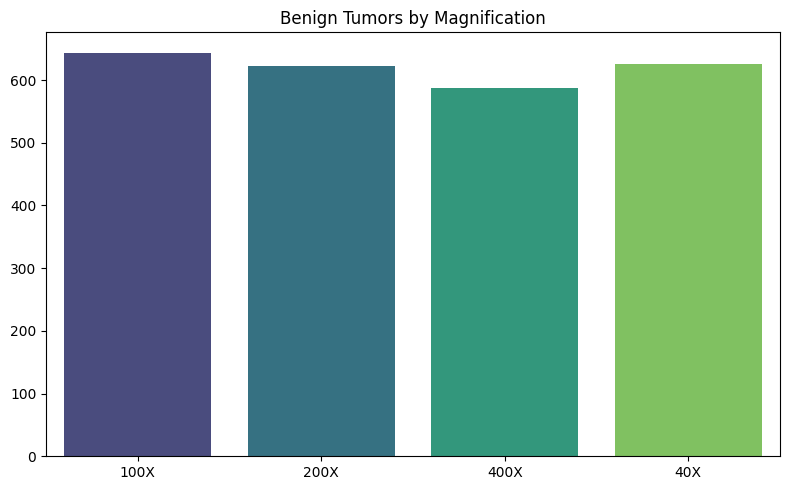

C:\Users\diogo\AppData\Local\Temp\ipykernel_31460\2926125085.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=malignant_grouped, x='Magnification', y='Count', palette='viridis')


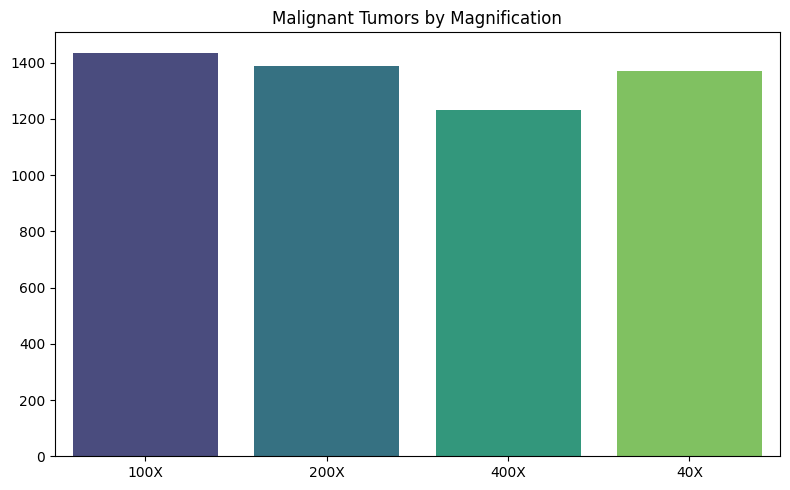

In [40]:
benign_data = df[df['Benign or Malignant'] == 'Benign']
malignant_data = df[df['Benign or Malignant'] == 'Malignant']

# Group for Benign tumors
benign_grouped = benign_data.groupby('Magnification').size().reset_index(name='Count')

# Group for Malignant tumors
malignant_grouped = malignant_data.groupby('Magnification').size().reset_index(name='Count')

# Plot for Benign tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=benign_grouped, x='Magnification', y='Count', palette='viridis')
plt.title('Benign Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot for Malignant tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=malignant_grouped, x='Magnification', y='Count', palette='viridis')
plt.title('Malignant Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Binary classification

#### Target variable and Train, test split

In [41]:
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array
# Flatten X (from 3D to 2D)
X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector

In [42]:
df['target'] = df['Benign or Malignant'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['target'].values  # Assuming the target is in a column 'target'

# Split the dataset into training and testing subsets
#X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

In [43]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state = 1, shuffle = True)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state = 1, stratify=y_train, shuffle=True)

In [44]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

In [45]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### Models

#### Model 1
##### 2 hidden layers with 16 hidden units each

In [46]:
# Build the Sequential model
model = Sequential()

# First hidden layer with input_dim specified
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


c:\Users\diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7088 - loss: 3.5605 - val_accuracy: 0.7580 - val_loss: 2.6696
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7751 - loss: 2.1874 - val_accuracy: 0.7749 - val_loss: 2.5925
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8162 - loss: 1.4631 - val_accuracy: 0.7825 - val_loss: 2.1810
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8244 - loss: 1.1863 - val_accuracy: 0.7884 - val_loss: 1.7206
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8465 - loss: 0.7743 - val_accuracy: 0.7782 - val_loss: 1.6291
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8770 - loss: 0.7805 - val_accuracy: 0.8137 - val_loss: 1.6348
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8967 - loss: 0.5769 - val_accuracy: 0.7960 - val_loss: 2.5694
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8920 - loss: 0.5644 - val_accuracy: 

In [47]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 16)             │     2,408,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,817,508 (18.38 MB)

 Trainable params: 2,408,753 (9.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,408,755 (9.19 MB)

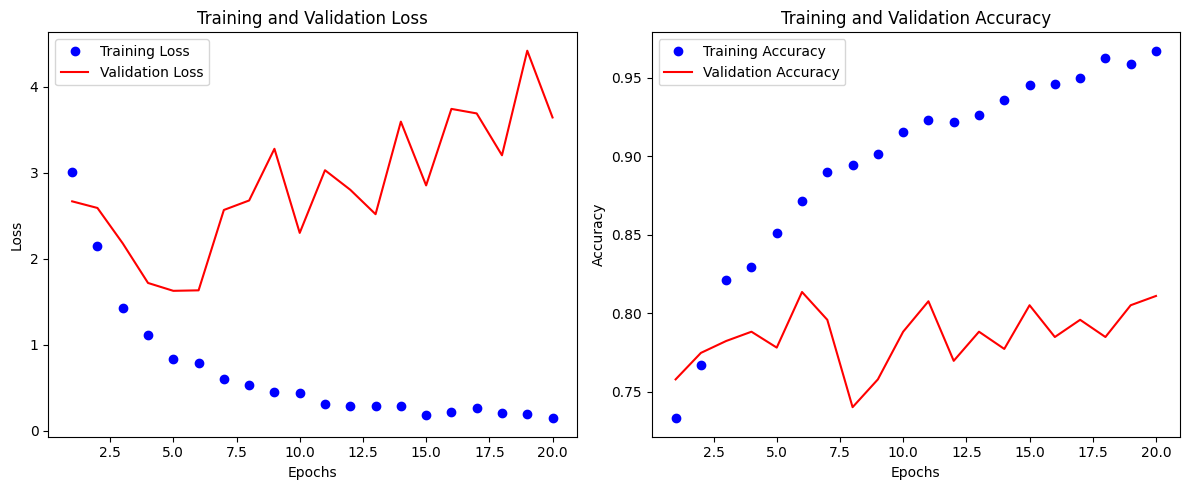

In [48]:
# Extracting data from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [49]:
# Evaluate the model on the test data
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 3.7288
Test Accuracy: 0.8180


In [50]:
# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Sample Predictions (Probability -> Binary):
Probability: 0.9999, Predicted Class: 1, Actual Class: 1
Probability: 0.9869, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.9994, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 0
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.0000, Predicted Class: 0, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.9999, Predicted Class: 1, Actual Class: 1



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.63      0.68       372
           1       0.84      0.91      0.87       815

    accuracy                           0.82      1187
   macro avg       0.80      0.77      0.78      1187
weighted avg       0.81      0.82      0.81      1187


ROC-AUC Score: 0.8408


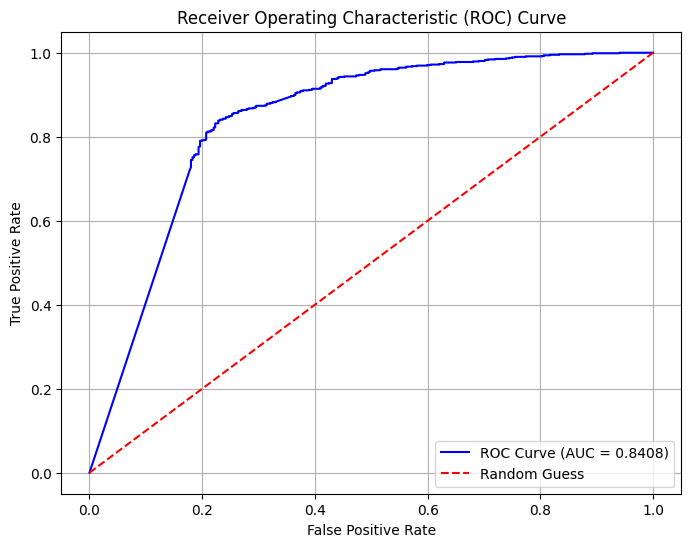

In [51]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 2
##### 3 hidden layers with 16 hidden units each
##### Tested 3 hidden layers with 32 units each, but the results were unsatisfactory

In [52]:
# Build the Sequential model
model_2 = Sequential()

# First hidden layer with input_dim specified and more hidden units
#model_2.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model_2.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer with more hidden units
#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

# Third hidden layer with more hidden units
#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

# Output layer for binary classification
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


c:\Users\diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7390 - loss: 5.5182 - val_accuracy: 0.7277 - val_loss: 2.2709
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7650 - loss: 1.6167 - val_accuracy: 0.7926 - val_loss: 1.1116
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8006 - loss: 0.7671 - val_accuracy: 0.7673 - val_loss: 0.6900
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8165 - loss: 0.5639 - val_accuracy: 0.7926 - val_loss: 0.7740
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8407 - loss: 0.5025 - val_accuracy: 0.7774 - val_loss: 0.7485
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8596 - loss: 0.3892 - val_accuracy: 0.7673 - val_loss: 0.9819
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8594 - loss: 0.3919 - val_accuracy: 0.7858 - val_loss: 0.9250
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8712 - loss: 0.3299 - val_accuracy: 0

In [53]:
model_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 16)             │     2,408,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,818,052 (18.38 MB)

 Trainable params: 2,409,025 (9.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,409,027 (9.19 MB)

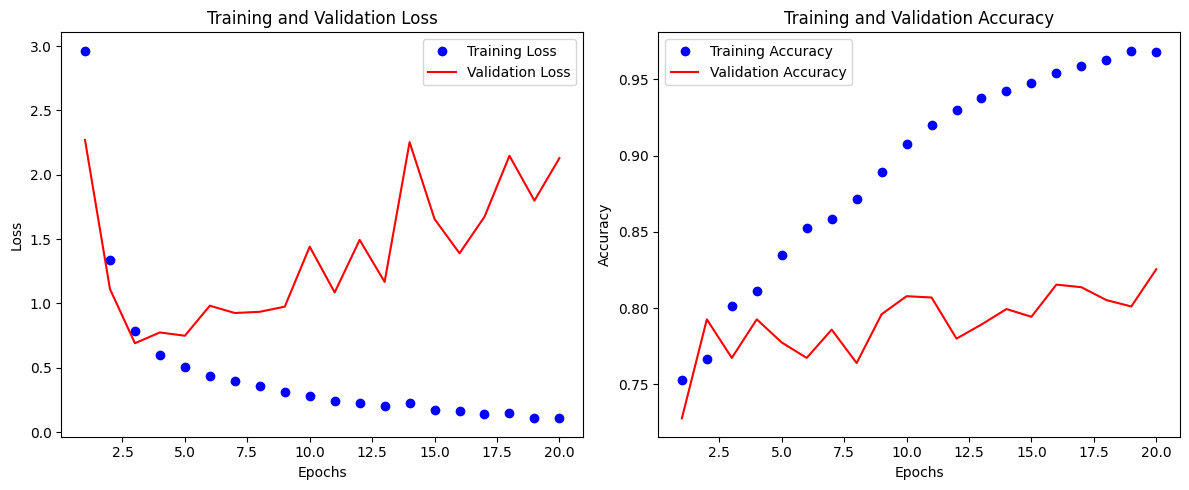

In [54]:
# Extracting data from the history object
history_dict = history_2.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [55]:
# Evaluate the model on the test data
results = model_2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 2.0785
Test Accuracy: 0.8450


In [56]:
# Generate predictions
y_pred_prob = model_2.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Sample Predictions (Probability -> Binary):
Probability: 0.9999, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.2788, Predicted Class: 0, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 0
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 0.0000, Predicted Class: 0, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1
Probability: 1.0000, Predicted Class: 1, Actual Class: 1



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       372
           1       0.87      0.91      0.89       815

    accuracy                           0.84      1187
   macro avg       0.82      0.81      0.82      1187
weighted avg       0.84      0.84      0.84      1187


ROC-AUC Score: 0.8602


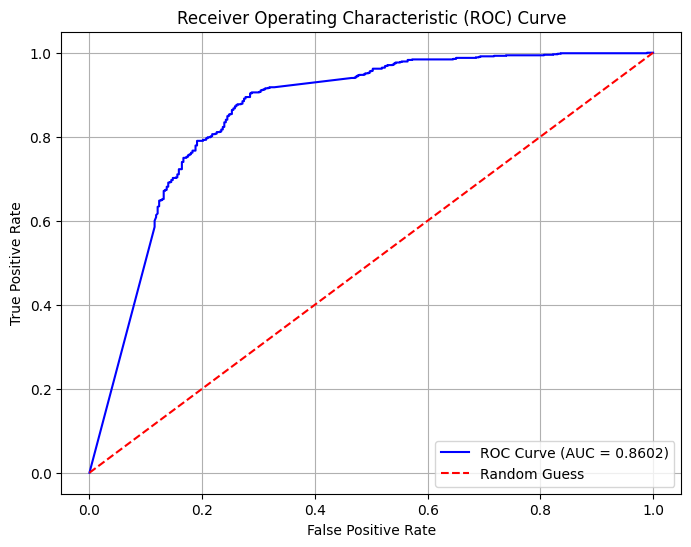

In [57]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 3
##### Equivalent to model 2 but with the loss function mse instead
##### Also tried tanh activation function 

In [58]:
# Build the Sequential model
model_3 = Sequential()

# First hidden layer with input_dim specified and more hidden units
#model_3.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model_3.add(Dense(16, activation='tanh', input_dim=X_train.shape[1]))

# Second hidden layer with more hidden units
#model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(16, activation='tanh'))

# Third hidden layer with more hidden units
#model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(16, activation='tanh'))

# Output layer for binary classification
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['accuracy'])

# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


c:\Users\diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6933 - loss: 0.1950 - val_accuracy: 0.7875 - val_loss: 0.1531
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8008 - loss: 0.1467 - val_accuracy: 0.7909 - val_loss: 0.1477
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8091 - loss: 0.1419 - val_accuracy: 0.7943 - val_loss: 0.1460
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8149 - loss: 0.1384 - val_accuracy: 0.7740 - val_loss: 0.1482
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7972 - loss: 0.1426 - val_accuracy: 0.8027 - val_loss: 0.1441
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8114 - loss: 0.1398 - val_accuracy: 0.7799 - val_loss: 0.1491
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8265 - loss: 0.1311 - val_accuracy: 0.7985 - val_loss: 0.1413
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8263 - loss: 0.1282 - val_accuracy: 0

In [59]:
model_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 16)             │     2,408,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,818,052 (18.38 MB)

 Trainable params: 2,409,025 (9.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,409,027 (9.19 MB)

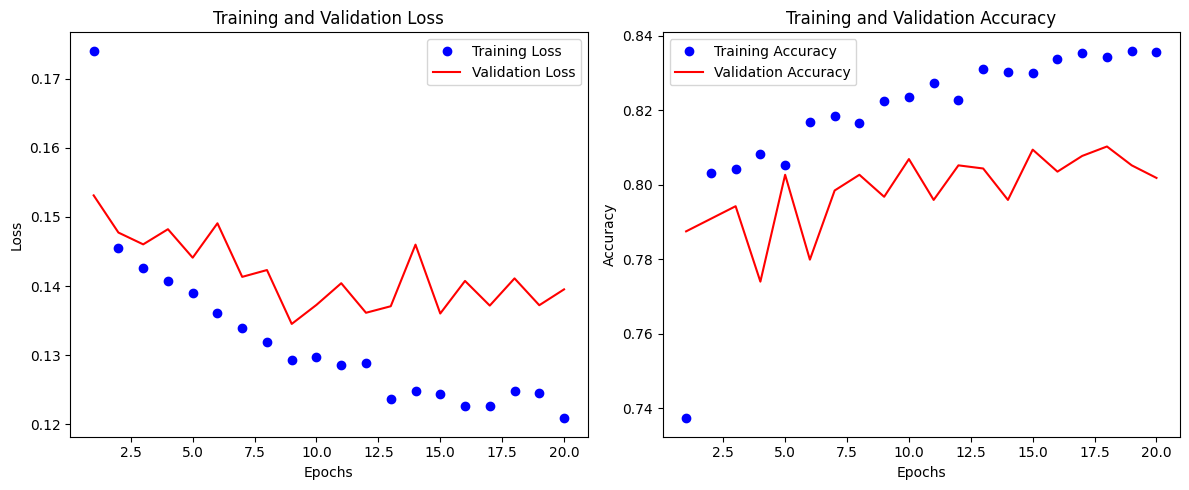

In [60]:
# Extracting data from the history object
history_dict = history_3.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [61]:
# Evaluate the model on the test data
results = model_3.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 0.1336
Test Accuracy: 0.8071


In [62]:
# Generate predictions
y_pred_prob = model_3.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Sample Predictions (Probability -> Binary):
Probability: 0.9531, Predicted Class: 1, Actual Class: 1
Probability: 0.4966, Predicted Class: 0, Actual Class: 1
Probability: 0.9708, Predicted Class: 1, Actual Class: 1
Probability: 0.6519, Predicted Class: 1, Actual Class: 1
Probability: 0.9206, Predicted Class: 1, Actual Class: 1
Probability: 0.9531, Predicted Class: 1, Actual Class: 0
Probability: 0.9822, Predicted Class: 1, Actual Class: 1
Probability: 0.0701, Predicted Class: 0, Actual Class: 1
Probability: 0.6450, Predicted Class: 1, Actual Class: 1
Probability: 0.8519, Predicted Class: 1, Actual Class: 1



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       372
           1       0.82      0.91      0.87       815

    accuracy                           0.81      1187
   macro avg       0.79      0.74      0.76      1187
weighted avg       0.80      0.81      0.80      1187


ROC-AUC Score: 0.8499


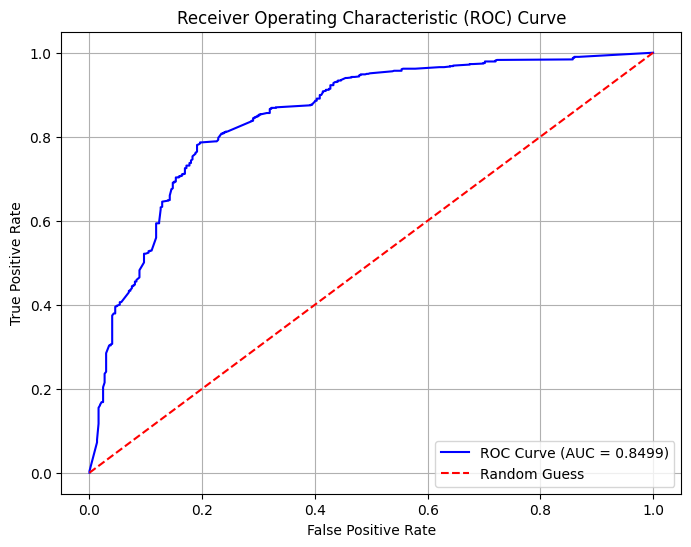

In [63]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 4
##### CNN implementation

In [64]:
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array

# Normalize the image data (pixel values between 0 and 1)
X = X / 255.0  # Scale pixel values to [0, 1]

df['target'] = df['Benign or Malignant'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['target'].values  # Assuming the target is in a column 'target'

# Split the dataset into training (70%), testing (15%), and validation (15%) subsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=1, shuffle=True)

# Verify the shapes of the splits
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (5536, 224, 224, 3), (5536,)
Validation data shape: (1186, 224, 224, 3), (1186,)
Test data shape: (1187, 224, 224, 3), (1187,)


In [65]:
'''
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array
# Flatten X (from 3D to 2D)
#X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
'''

"\nX = np.array(df['image_data'].tolist())  # Convert Series to a numpy array\n# Flatten X (from 3D to 2D)\n#X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector\n\nX_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)\nX_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)\n\n# Scale the features\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\nX_val = scaler.transform(X_val)\n"

In [68]:
# Build the CNN model
model_4 = Sequential()

# First convolutional layer
model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model_4.add(Flatten())

# Fully connected layers
model_4.add(Dense(64, activation='relu'))  # First dense layer
model_4.add(Dense(16, activation='relu'))  # Second dense layer

# Output layer for binary classification
model_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_4.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',  # Binary crossentropy is better for binary classification
                metrics=['accuracy'])

# Train the model
history_4 = model_4.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


c:\Users\diogo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 244ms/step - accuracy: 0.6732 - loss: 0.6359 - val_accuracy: 0.8373 - val_loss: 0.4459
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.7911 - loss: 0.4830 - val_accuracy: 0.7454 - val_loss: 0.5766
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.8115 - loss: 0.4634 - val_accuracy: 0.7884 - val_loss: 0.4954
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.8116 - loss: 0.4453 - val_accuracy: 0.8339 - val_loss: 0.4256
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.8353 - loss: 0.4242 - val_accuracy: 0.8347 - val_loss: 0.4124
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 39s 213ms/step - accuracy: 0.8289 - loss: 0.4232 - val_accuracy: 0.8474 - val_loss: 0.3745
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.8224 - loss: 0.4271 - val_accuracy: 0.8533 - val_loss: 0.4182
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 39s 209ms/step - accuracy: 0.8350 - loss: 0

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       372
           1       0.88      0.97      0.92       815

    accuracy                           0.89      1187
   macro avg       0.89      0.84      0.86      1187
weighted avg       0.89      0.89      0.88      1187


ROC-AUC Score: 0.9438


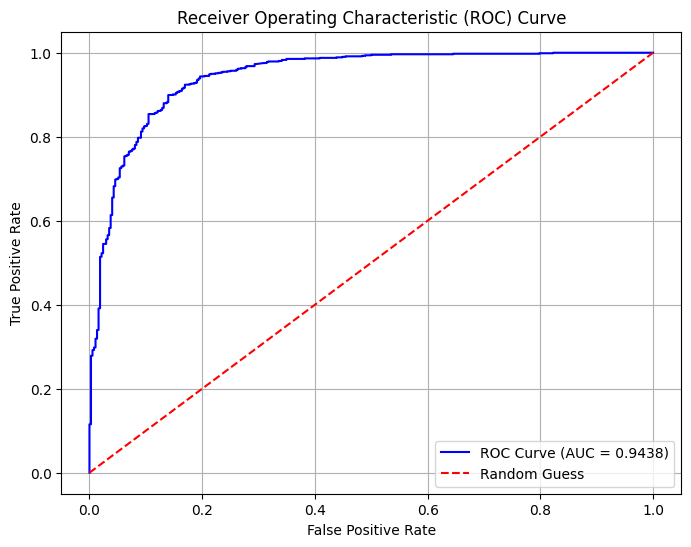

In [71]:
predictions = model_4.predict(X_test)

# Convert probabilities to binary labels
y_pred = (predictions > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

<h1> Pre-trained models </h1>

In [33]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (optional)
base_model.trainable = False

# Add custom layers for binary or multi-class classification
model_ResNet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
    # Use Dense(8, activation='softmax') for multi-class classification
])

# Compile the model
model_ResNet50.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy','precision','recall']) #binary
#model_ResNet50.compile(optimizer=Adam(learning_rate=0.001), loss='crossentropy', metrics=['accuracy','precision','recall']) #multiclass

In [ ]:
model_ResNet50.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10


ValueError: Input 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 150, 150, 3)

In [36]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 67500), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32, 67500)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 67500), dtype=float32)
  • training=False
  • mask=None

In [44]:
# Load VGG16 without the top layer (pre-trained on ImageNet)
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (optional)
base_model_vgg16.trainable = False

# Add custom layers for binary or multi-class classification
model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
    # Use Dense(8, activation='softmax') for multi-class classification (e.g., 8 cancer types)
])

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy','precision','recall'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [45]:
model_vgg16.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 67500), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32, 67500)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 67500), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# Predict and evaluate
y_pred_vgg16 = model_vgg16.predict(X_test)
y_pred_vgg16 = np.round(y_pred_vgg16)
print(classification_report(y_test, y_pred_vgg16))
print(confusion_matrix(y_test, y_pred_vgg16))